In [1]:
options(jupyter.plot_mimetypes = c("image/png"))

suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggrepel))

## For loading Arial font for publication
# library(extrafont)

# font_import(pattern = "Arial", prompt = FALSE)
# loadfonts(device = "pdf")

Warning message:
“package ‘ggrepel’ was built under R version 4.4.3”


In [2]:
# Read the master df
master_csv <- "resources/recessive.cross_studies_comparison.csv"
data <- read.csv(file = master_csv, header = TRUE, sep = ",", stringsAsFactors = FALSE, na.strings = "ND")

In [3]:
# Add log2 transformed columns for all relevant populations
for (pop in c("NFE", "EAS", "AFR")) {
  col <- paste0("carrier_rate_gnomAD.", pop)
  log2_col <- paste0("log2_carrier_rate_gnomAD.", pop)
  data[[log2_col]] <- ifelse(!is.na(data[[col]]), log2(data[[col]] + 1e-6), NA)
}

data$log2_carrier_rate_hkgi <- ifelse(!is.na(data$carrier_rate_hkgi), log2(data$carrier_rate_hkgi + 1e-6), NA)

# Map tier strings to integers
map_tier_to_int <- function(tier) {
  if (tier == "tier_1") {
    return(1)
  } else if (tier == "tier_2") {
    return(2)
  } else if (tier == "tier_3") {
    return(3)
  } else if (tier == "tier_4") {
    return(4)
  } else {
    return(NA)
  }
}

data$tier_hkgi_num <- sapply(data$tier_hkgi, map_tier_to_int)
data$acmg_tier_hkgi_num <- sapply(data$acmg_tier_hkgi, map_tier_to_int)

data$tier_change <- ifelse(
  is.na(data$tier_hkgi_num) | is.na(data$acmg_tier_hkgi_num), NA,
  ifelse(data$tier_hkgi_num > data$acmg_tier_hkgi_num, "lower_tier",
         ifelse(data$tier_hkgi_num < data$acmg_tier_hkgi_num, "higher_tier", "same"))
)

In [4]:
# Filter out genes with carrier_count_hkgi < 1 and keep only tier 1 and 2 genes
#plot_data <- subset(data, carrier_count_hkgi >= 1 & acmg_tier_hkgi %in% c("tier_1", "tier_2", "tier_3"))

# Filter out genes with carrier_count_hkgi < 1 and tier 4 genes that stayed the same
plot_data <- subset(data, carrier_count_hkgi >= 1 & !(tier_hkgi == "tier_4" & tier_change == "same"))

In [5]:
# Define tier colors
TIER_COLORS <- c(
  "Tier 1" = "#6F9BFF",
  "Tier 2" = "#E2695F",
  "Tier 3" = "#4de9ab",
  "Others" = "#FEE54C"
)

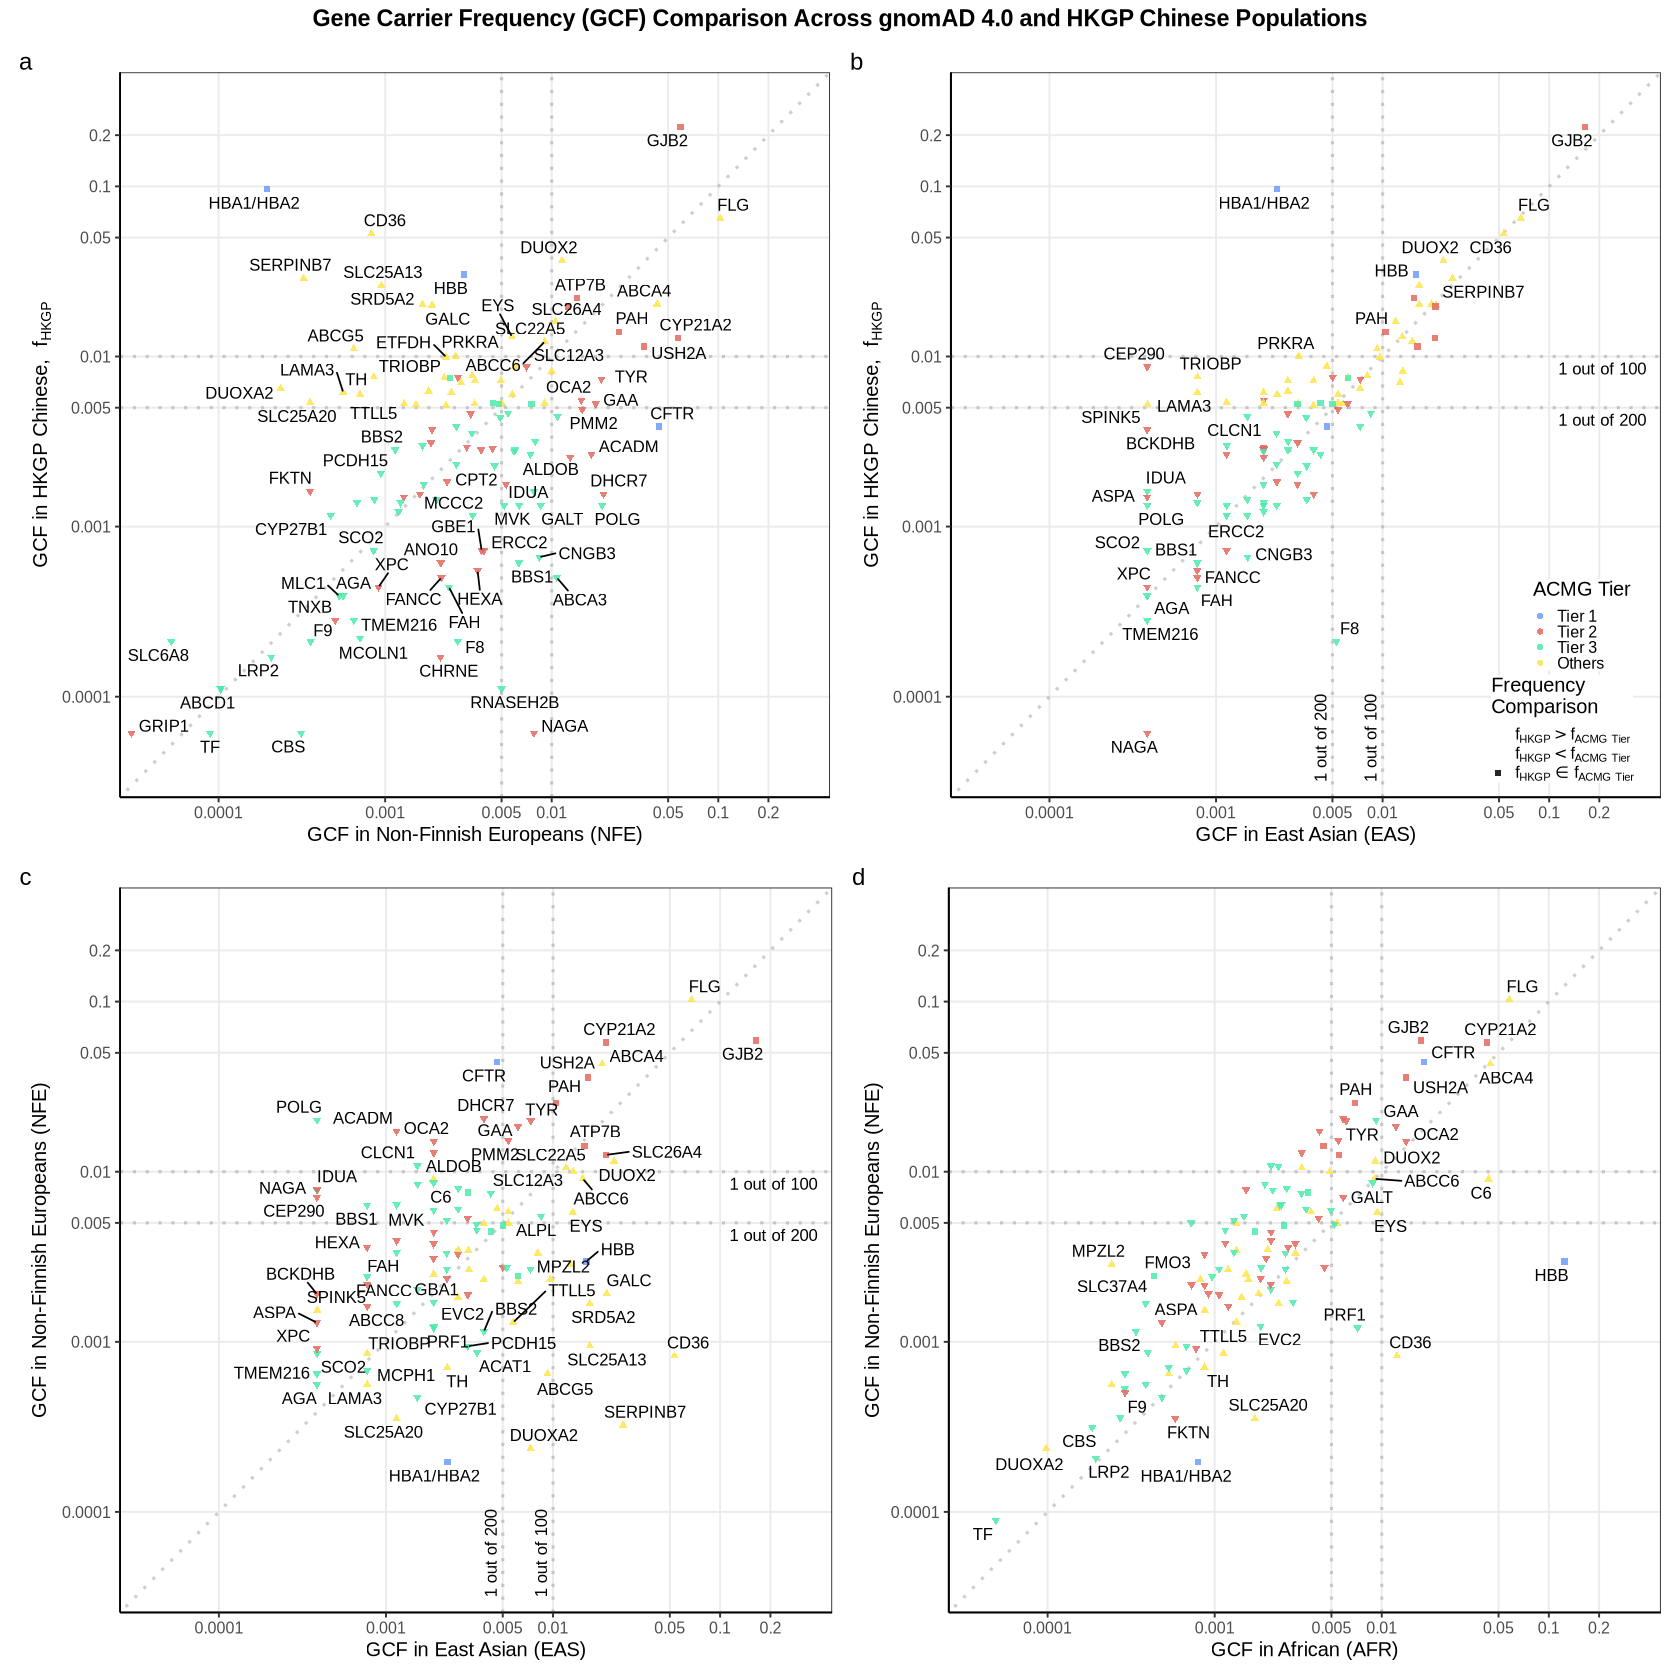

In [6]:
# Suppress the many warning messages. Turn this off to debug.
options(warn = -1)

# Manual axis limits
use_manual_limits <- TRUE
manual_x_limits <- c(log2(0.00004), log2(0.3))
manual_y_limits <- c(log2(0.00004), log2(0.3))

# Function to convert points to millimeters
pt_to_mm <- function(pt) pt * 0.352778

# Function to create a single plot for a given population
make_plot <- function(x_pop, y_pop, xlab, ylab = NULL, show_annotations = FALSE, show_legend = FALSE) {
  x_col <- paste0("log2_carrier_rate_gnomAD.", x_pop)
  y_col <- if (y_pop == "hkgi") "log2_carrier_rate_hkgi" else paste0("log2_carrier_rate_gnomAD.", y_pop)
  axis_range_x <- range(plot_data[[x_col]], na.rm=TRUE)
  axis_range_y <- range(plot_data[[y_col]], na.rm=TRUE)
  xlim <- if (use_manual_limits) manual_x_limits else axis_range_x
  ylim <- if (use_manual_limits) manual_y_limits else axis_range_y
  p <- ggplot() +
    geom_abline(linetype = "dotted", color = "gray62", alpha = 0.5, size = 0.9) +
    geom_hline(yintercept = log2(0.005 + 1e-6), linetype = "dotted", color = "gray62", alpha = 0.5, size = 0.9) +
    geom_hline(yintercept = log2(0.01 + 1e-6), linetype = "dotted", color = "gray62", alpha = 0.5, size = 0.9) +
    geom_vline(xintercept = log2(0.005 + 1e-6), linetype = "dotted", color = "gray62", alpha = 0.5, size = 0.9) +
    geom_vline(xintercept = log2(0.01 + 1e-6), linetype = "dotted", color = "gray62", alpha = 0.5, size = 0.9)
  if (show_annotations) {
    if (use_manual_limits) {
      annotation_text_x <- manual_x_limits[2]
      annotation_text_y <- manual_y_limits[1]
    } else {
      annotation_text_x <- axis_range_x[2]
      annotation_text_y <- axis_range_y[1]
    }
    p <- p +
      annotate("text", x = annotation_text_x, y = log2(0.005 + 1e-6), label = expression("1 out of 200"), hjust = 0.8, vjust = 1.5, 
               # family = "Arial",
               # size = 6/ggplot2::.pt
               size = 10/ggplot2::.pt
              ) +
      annotate("text", x = annotation_text_x, y = log2(0.01 + 1e-6), label = expression("1 out of 100"), hjust = 0.8, vjust = 1.5, 
               # family = "Arial",
               # size = 6/ggplot2::.pt
               size = 10/ggplot2::.pt
              ) +
      # Bottom ones
      annotate("text", x = log2(0.005 + 1e-6), y = annotation_text_y, label = expression("1 out of 200"), angle = 90, hjust = 0.2, vjust = -0.5, 
               # family = "Arial",
               # size = 6/ggplot2::.pt
               size = 10/ggplot2::.pt
              ) +
      annotate("text", x = log2(0.01 + 1e-6), y = annotation_text_y, label = expression("1 out of 100"), angle = 90, hjust = 0.2, vjust = -0.5, 
               # family = "Arial",
               # size = 6/ggplot2::.pt
               size = 10/ggplot2::.pt
              )
  }
  p <- p +
    geom_point(
      data = plot_data,
      aes_string(
        x = x_col,
        y = y_col,
        color = "factor(acmg_tier_hkgi, levels = c('tier_1', 'tier_2', 'tier_3', 'tier_4'), labels = c('Tier 1', 'Tier 2', 'Tier 3', 'Others'))",
        shape = "tier_change",
        fill = "factor(acmg_tier_hkgi, levels = c('tier_1', 'tier_2', 'tier_3', 'tier_4'), labels = c('Tier 1', 'Tier 2', 'Tier 3', 'Others'))"
      ),
      size = 1.8,
      # stroke = 0.5,
      stroke = 0,
      alpha = 0.85
    ) +
    scale_color_manual(
      values = TIER_COLORS,
      name = "ACMG Tier",
      na.translate = FALSE
    ) +
    scale_fill_manual(
      values = TIER_COLORS,
      guide = "none"
    ) +
    scale_shape_manual(
      values = c("same" = 15, "higher_tier" = 24, "lower_tier" = 25),
      name = "Frequency\nComparison",
      labels = c("same" = expression(f[HKGP] ~ "\u2208" ~ f[ACMG~Tier]), 
                "higher_tier" = expression(f[HKGP] > f[ACMG~Tier]), 
                "lower_tier" = expression(f[HKGP] < f[ACMG~Tier])),
      na.translate = FALSE
    ) +
    scale_x_continuous(
      breaks = log2(c(0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5)),
      labels = c("0.0001", "0.001", "0.005", "0.01", "0.05", "0.1", "0.2", "0.5")
    ) +
    scale_y_continuous(
      breaks = log2(c(0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5)),
      labels = c("0.0001", "0.001", "0.005", "0.01", "0.05", "0.1", "0.2", "0.5")
    ) +
    geom_text_repel(
      data = subset(plot_data, (tier_change %in% c("lower_tier", "higher_tier") | tier_hkgi_num %in% c(1,2,3)) & !(gene %in% c("MID1"))),
      aes_string(x = x_col, y = y_col, label = "gene"),
      size = 10/ggplot2::.pt, 
        # size = 5/ggplot2::.pt, 
        # family = "Arial", 
        box.padding = 0.23, max.overlaps = 9, color = "black",
      seed = 999
    ) +
    coord_cartesian(xlim = xlim, ylim = ylim) +
    # theme_bw(base_family = "Arial", base_size = 7) +
    theme_bw(base_size = 12) +
    theme(
        panel.grid.minor = element_blank(),
        # text = element_text(size = 6),
        # axis.text = element_text(size = 6),         # The grid numbers like 0.001, 0.01, etc.
        # axis.title = element_text(size = 7),        # The x and y axis labels
        axis.line = element_line(color = "black"),
        plot.mergin = margin(0, 0, 0, 0), # reduce margins (top, right, bottom, left)
    ) +
    labs(x = xlab, y = ylab)

    if (show_legend) {
      p <- p + 
        theme(
          legend.position = c(0.96, 0.02),
          legend.justification = c(1, 0),
          # legend.title = element_text(size = 6),
          # legend.text = element_text(size = 5),
          legend.spacing.y = unit(0.1, "cm"),
          legend.key.size = unit(0.3, "cm"),
          legend.background = element_rect(fill = "white", color = NA),
          legend.margin = margin(t = 0, r = 0, b = 0, l = 0),
          legend.box.margin = margin(t = 0, r = 0, b = 0, l = 0),
          # legend.box
          legend.box = "vertical",
          legend.box.just = "right"
          # legend.position = "right"
        )
    } else {
      p <- p + theme(legend.position = "none")
    }
    return(p)
}

# ##### NFE individual plot #####
# p2 <- make_plot("NFE", "gnomAD 4.0 GCF in Non-Finnish Europeans", expression("HKGP Chinese GCF, "~f[HKGP]), show_annotations = TRUE)
# p2

p0 <- make_plot("NFE", "hkgi", "GCF in Non-Finnish Europeans (NFE)", expression("GCF in HKGP Chinese, "~f[HKGP]), show_annotations = FALSE)
# 1. Upper left: HKGP vs EAS (y = HKGP, x = EAS)
p1 <- make_plot("EAS", "hkgi", "GCF in East Asian (EAS)", expression("GCF in HKGP Chinese, "~f[HKGP]), show_annotations = TRUE, show_legend = TRUE)
# p1 <- make_plot("EAS", "hkgi", "gnomAD 4.0 GCF in EAS", expression("HKGP Chinese GCF, "~f[HKGP]), show_annotations = TRUE)
# 2. Upper right: HKGP vs NFE (y = HKGP, x = NFE)
p2 <- make_plot("EAS", "NFE", "GCF in East Asian (EAS)", "GCF in Non-Finnish Europeans (NFE)", show_annotations = TRUE)

p3 <- make_plot("AFR", "NFE", "GCF in African (AFR)", "GCF in Non-Finnish Europeans (NFE)", show_annotations = FALSE, show_legend = FALSE)

# multi_panel_plot <- p1 + p2 + p3 + plot_layout(ncol = 3, guides = "collect")
multi_panel_plot <- (p0 | p1) / (p2 | p3) + 
  # plot_layout(guides = "collect") +
  plot_annotation(
    title = "Gene Carrier Frequency (GCF) Comparison Across gnomAD 4.0 and HKGP Chinese Populations",
    theme = theme(
      plot.title = element_text(
        face = "bold",         # Bold font
        size = 14,             # Adjust title font size (pt)
        hjust = 0.5,           # Center the title
        # family = "Arial"       # Arial font family
      )
    )
  ) +
  plot_annotation(tag_levels = "a") +
  theme(
    plot.tag = element_text(
      face = "bold",      # Makes the tags bold
      size = 12,          # 12pt size
      # family = "Arial"    # Arial font
    )
  )
# Set plot size (in inches)
options(repr.plot.width = 14, repr.plot.height = 14)
multi_panel_plot

In [7]:
## Save to PDF
# ggsave(
#   filename = "results/GCF_scatter.gnomAD_4.0.multi_panel.v1.nature.pdf",
#   plot = multi_panel_plot,
#   # width = 210, # double column width 180mm
#   # height = 190,  # height in inches (≤185 mm)
#   width = 180, # double column width 180mm
#   height = 162,  # height in inches (≤185 mm)
#   units = "mm",
#   dpi = 600
# )